In [2]:
!pip install transformers
!pip install sentencepiece

In [4]:
!pip install nltk

In [5]:
import pandas as pd
import numpy as np
import random
import joblib
import torch

from sklearn import preprocessing
from sklearn import model_selection
# from DataAugmentation 
from DataAugmentation import DataAugmentation
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from importlib import reload
import config
from transformers import XLMRobertaForTokenClassification, XLMRobertaConfig ,BertModel, XLMRobertaTokenizer, XLMRobertaModel, BertForTokenClassification
from data_utils import loadDatafromFile,createTokenizedDf,CompDataset,createkfoldData,createDataloaders
from seqeval.metrics import accuracy_score, classification_report
import engine
from model_new import EntityModel
import torch.nn as nn
from tqdm import tqdm

In [6]:
# Read the data
def process_data(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags):
    
    dataObj = loadDatafromFile(filePath_src,filePath_tar, filePath_srcTags,filePath_tarTags)
    df= dataObj.createDf() # get dataframe from files
    obj_tokenized = createTokenizedDf(df)
    df_new= obj_tokenized.convertDf()
    enc_label = preprocessing.LabelEncoder()
    df_new['labels']= enc_label.fit_transform(df_new['labels'])
    train_data = CompDataset(df_new)
    return train_data


In [9]:
# if loading of the non augmented (noise-free) data is needed, then run this
# dataset_train = process_data(config.filePath_src,config.filePath_tar, config.filePath_srcTags,config.filePath_tarTags)
# len(dataset_train)

7000

In [7]:
#loading dev/eval data
dataset_eval = process_data(config.filePath_src_eval,config.filePath_tar_eval, config.filePath_srcTags_eval,config.filePath_tarTags_eval)
len(dataset_eval)

1000

AttributeError: type object 'DataAugmentation' has no attribute 'DataAugmentation'

In [8]:
dataObj = loadDatafromFile(config.filePath_src,config.filePath_tar, config.filePath_srcTags,config.filePath_tarTags)
df= dataObj.createDf() 
df
# list(df.source)

,source,target,src_tokens,tar_tokens
0,José Ortega y Gasset visited Husserl at Freibu...,1934 besuchte José Ortega y Gasset Husserl in ...,OK OK OK OK BAD OK OK OK BAD BAD OK,OK BAD OK BAD OK OK OK OK OK OK OK OK BAD OK O...
1,"however , a disappointing ninth in China meant...",eine enttäuschende Neunte in China bedeutete j...,OK BAD BAD BAD BAD OK OK OK OK OK OK OK OK OK ...,BAD BAD OK BAD OK BAD OK OK OK OK OK OK OK OK ...
2,"in his diary , Chase wrote that the release of...","in seinem Tagebuch , Chase schrieb , dass die ...",OK OK OK OK OK BAD OK OK BAD OK OK BAD OK BAD ...,OK OK OK OK OK OK OK BAD OK OK OK BAD OK OK OK...
3,Heavy arquebuses mounted on wagons were called...,schwere Arquebuses auf Waggons montiert wurden...,BAD BAD OK OK BAD BAD BAD OK OK OK OK,OK OK BAD BAD OK OK OK BAD OK OK BAD OK BAD OK...
4,once North Pacific salmon die off after spawni...,sobald der nordpazifische Lachs nach dem Laich...,OK OK OK OK OK OK OK BAD OK BAD BAD BAD BAD OK...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK BAD ...
...,...,...,...,...
6995,some may also discourage or disallow unsanitar...,einige können auch unhygienische Praktiken wie...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK BAD ...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
6996,"in the late 1860s , the crinolines disappeared...",in den späten 1860er Jahren verschwanden die K...,OK OK OK OK OK OK OK BAD OK BAD BAD BAD OK OK ...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK B...
6997,"disco was criticized as mindless , consumerist...","Disco wurde als geistlos , konsumistisch , übe...",OK OK OK OK BAD BAD OK OK OK BAD OK OK,OK OK OK OK OK OK OK BAD OK OK OK BAD OK OK OK...
6998,planters would then fill large hogsheads with ...,die Pflanzer würden dann große Heuschrecken mi...,OK OK BAD OK OK BAD OK OK OK OK BAD BAD BAD BA...,OK OK OK OK OK BAD OK OK OK OK OK BAD OK OK OK...


In [30]:
reload(DataAugmentation)
from DataAugmentation import DataAugmentation

In [10]:
dataaug_obj = DataAugmentation(df,swap_words=2,syn_words=2,del_words_prob=0.2,num_sentences=10)  
swapDataset = dataaug_obj.random_swap()
del_augDataset = dataaug_obj.random_deletion()
del_augDataset = del_augDataset[7000:]
syn_dataset = dataaug_obj.synonym_replacement()
syn_dataset = syn_dataset[7000:]
frames = [swapDataset , del_augDataset,syn_dataset]
aug_df  = pd.concat(frames)
aug_df

,source,target,src_tokens,tar_tokens
0,José Ortega y Gasset visited Husserl at Freibu...,1934 besuchte José Ortega y Gasset Husserl in ...,OK OK OK OK BAD OK OK OK BAD BAD OK,OK BAD OK BAD OK OK OK OK OK OK OK OK BAD OK O...
1,"however , a disappointing ninth in China meant...",eine enttäuschende Neunte in China bedeutete j...,OK BAD BAD BAD BAD OK OK OK OK OK OK OK OK OK ...,BAD BAD OK BAD OK BAD OK OK OK OK OK OK OK OK ...
2,"in his diary , Chase wrote that the release of...","in seinem Tagebuch , Chase schrieb , dass die ...",OK OK OK OK OK BAD OK OK BAD OK OK BAD OK BAD ...,OK OK OK OK OK OK OK BAD OK OK OK BAD OK OK OK...
3,Heavy arquebuses mounted on wagons were called...,schwere Arquebuses auf Waggons montiert wurden...,BAD BAD OK OK BAD BAD BAD OK OK OK OK,OK OK BAD BAD OK OK OK BAD OK OK BAD OK BAD OK...
4,once North Pacific salmon die off after spawni...,sobald der nordpazifische Lachs nach dem Laich...,OK OK OK OK OK OK OK BAD OK BAD BAD BAD BAD OK...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK BAD ...
...,...,...,...,...
76995,"he mass Krishna 's most grave enemy , Jarasand...",er tötete Krishnas gefährlichsten Feind Jarasa...,OK BAD OK OK OK OK OK OK OK OK OK BAD BAD OK O...,OK OK OK BAD OK OK OK OK OK OK OK OK OK OK OK ...
76996,he great deal Krishna 's most dangerous enemy ...,er tötete Krishnas gefährlichsten Feind Jarasa...,OK BAD BAD OK OK OK OK OK OK OK OK OK BAD BAD ...,OK OK OK BAD OK OK OK OK OK OK OK OK OK OK OK ...
76997,"he slew Krishna 's most dangerous enemy , Jara...",er tötete Krishnas gefährlichsten Feind Jarasa...,OK BAD OK OK OK OK OK OK OK OK OK BAD BAD OK O...,OK OK OK BAD OK OK OK OK OK OK OK OK OK OK OK ...
76998,"he slue Krishna 's most dangerous enemy , Jara...",er tötete Krishnas gefährlichsten Feind Jarasa...,OK BAD OK OK OK OK OK OK OK OK OK BAD BAD OK O...,OK OK OK BAD OK OK OK OK OK OK OK OK OK OK OK ...


In [11]:
aug_df =aug_df.sample(frac=1).reset_index(drop=True)
aug_df

,source,target,src_tokens,tar_tokens
0,"Germany invaded France , , Luxembourg and the ...",Deutschland marschierte am 10. Mai 1940 in Fra...,OK OK OK OK OK OK OK BAD BAD OK OK OK,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
1,the enzyme chitinase grow in the stomach helps...,das im Magen produzierte Enzym Chitinase hilft...,OK OK OK OK OK BAD OK BAD BAD BAD BAD BAD BAD ...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK BAD ...
2,"Roger Rousseau , The French Foreign Legion in ...","Roger Rousseau , Die französische Fremdenlegio...",OK OK OK BAD OK BAD BAD OK OK OK OK OK,OK OK OK OK OK OK OK BAD OK OK BAD BAD OK OK O...
3,"in 1927 , Lieutenant Jaime Sabater , from San ...",1927 absolvierte Lieutenant Jaime Sabater aus ...,BAD OK OK BAD OK OK OK OK OK OK OK OK OK OK OK...,BAD OK OK OK OK BAD OK OK OK OK OK OK OK OK OK...
4,blackmails Sharon into meeting him at a motel,"Cameron erpresst Sharon , ihn in einem Motel z...",BAD BAD BAD OK OK OK OK OK,OK OK OK BAD OK OK BAD OK OK OK OK OK OK OK OK...
...,...,...,...,...
216995,maxilla baleen exclusively the in the sit jaw ...,die Zähne oder Baleen im Oberkiefer sitzen aus...,OK OK OK OK BAD OK OK OK OK OK OK OK OK OK,OK OK OK OK OK OK OK BAD OK OK OK OK OK OK OK ...
216996,the with clock with mainspring either 's motor...,die Hauptfeder der elektrischen Uhr wird entwe...,OK OK OK OK OK OK OK OK OK OK OK BAD OK OK OK ...,OK OK OK OK OK OK OK OK OK OK OK OK OK OK OK O...
216997,he accidentally frivol away Jane during an alt...,er schießt Jane versehentlich während einer Au...,OK OK BAD BAD OK OK OK OK OK OK OK OK OK OK OK...,OK OK OK BAD OK OK OK OK OK OK OK OK OK OK OK ...
216998,"Paul Collier disability advocate , Australian ...","Paul Collier , 46 , australischer Behindertena...",OK OK BAD BAD OK OK OK OK OK OK OK OK,OK OK OK OK OK OK OK OK OK OK OK OK BAD BAD OK...


In [12]:
# #DataAugmentation methods
# def random_swap(dataframe,n): # n is number of times to swap randomly 2 words
    
#     source_sentences  = list(dataframe.source)
#     target_sentences = list(dataframe.target)
#     labels_src = list(dataframe.src_tokens)
#     labels_tar = list(dataframe.tar_tokens)
#     source_sentences_temp =[]
#     labels_sec_temp=[]
#     i=0
    
#     for sentences, labels in zip(source_sentences,labels_src):
        
#         sentences = sentences.split()
#         labels = labels.split()
        
#         for _ in range(5):
#             for _ in range(n):
#                 sentences, labels = swap_word(sentences,labels)
#             assert(len(sentences) == len(labels))
#             sentences_str = ' '.join(sentences)
#             labels_str = ' '.join(labels)
#             target_sentences.append(target_sentences[i])
#             labels_tar.append(labels_tar[i])
#             source_sentences_temp.append(sentences_str)
#             labels_sec_temp.append(labels_str)
        
# #         break
#         i+=1
    
#     source_sentences.extend(source_sentences_temp)
#     labels_src.extend(labels_sec_temp)
# #     print(source_sentences)
# #     print(labels_src)
#     column_names = ["source","target","src_tokens","tar_tokens"]
#     df = pd.DataFrame(columns=column_names,dtype=object)
#     df = df.assign(source=source_sentences)
#     df = df.assign(target = target_sentences)
#     df = df.assign(src_tokens = labels_src)
#     df = df.assign(tar_tokens = labels_tar)
    
#     return df

# def swap_word(new_words,labels_src):

#     random_idx_1 = random.randint(0, len(new_words)-1)
#     random_idx_2 = random_idx_1
#     counter = 0
#     while random_idx_2 == random_idx_1:
#         random_idx_2 = random.randint(0, len(new_words)-1)
#         counter += 1
#         if counter > 3:
#             return (new_words,labels_src)
#     new_words[random_idx_1], new_words[random_idx_2] = new_words[random_idx_2], new_words[random_idx_1]
#     labels_src[random_idx_1], labels_src[random_idx_2] = labels_src[random_idx_2], labels_src[random_idx_1]
# #     print(labels_src)
# #     new_str = ''.join(new_words)
#     return (new_words, labels_src)

In [34]:
# new_df = random_swap(df,2) # tune how much words you want to swap
# # new_df = new_df.sample(frac=1).reset_index(drop=True) # shuffling the dafaframe with resetting the index
# print(new_df.iloc[0].values)
# print(new_df.iloc[7000].values)
# print(new_df.iloc[7001].values)
# print(new_df.iloc[7002].values)
# print(new_df.iloc[7003].values)
# print(new_df.iloc[7004].values)

In [33]:
# def random_deletion(dataframe, p):
    
#     source_sentences  = list(dataframe.source)
#     target_sentences = list(dataframe.target)
#     labels_src = list(dataframe.src_tokens)
#     labels_tar = list(dataframe.tar_tokens)
#     senetences_temp=[]
#     labels_temp= []
#     #randomly delete words with probability p
#     i=0
#     for sentences, labels in zip(source_sentences,labels_src):
            
#         sentences = sentences.split()
#         labels = labels.split() 
        
        
        
#         if len(sentences) == 1:
#             i+=1
#             continue
            
        
               
#         for _ in range(5):
            
#             source_sentences_temp=[]
#             labels_sec_temp=[]
#             for word,label in zip(sentences,labels):
#                 r = random.uniform(0, 1)
#                 if r > p:
#                     source_sentences_temp.append(word)
#                     labels_sec_temp.append(label)
#             if len(source_sentences_temp) == 0: #if you end up deleting all words, just return a random word
#                 rand_int = random.randint(0, len(source_sentences_temp)-1)
#                 source_sentences_temp.append(sentences[rand_int])
#                 labels_sec_temp.append(labels[rand_int])
#             assert(len(source_sentences_temp) == len(labels_sec_temp))
#             sentences_str = ' '.join(source_sentences_temp)
#             labels_str = ' '.join(labels_sec_temp)
#             senetences_temp.append(sentences_str)
#             labels_temp.append(labels_str)
#             target_sentences.append(target_sentences[i])
#             labels_tar.append(labels_tar[i])
# #         break
#         i+=1
#     source_sentences.extend(senetences_temp)
#     labels_src.extend(labels_temp)    
#     column_names = ["source","target","src_tokens","tar_tokens"]
#     df = pd.DataFrame(columns=column_names,dtype=object)
#     df = df.assign(source=source_sentences)
#     df = df.assign(target = target_sentences)
#     df = df.assign(src_tokens = labels_src)
#     df = df.assign(tar_tokens = labels_tar)  


#     return df

In [20]:
# train_data, test_data= model_selection.train_test_split(dataset, random_state = 34, test_size=0.1)

In [32]:

# augmented_dataset = random_deletion(df,0.2) # probabality of deleting the tokens
# augmented_dataset

In [38]:
# print(augmented_dataset.iloc[0].values)
# print(augmented_dataset.iloc[0].values)

# print(augmented_dataset.iloc[7003].values)
# print(augmented_dataset.iloc[7004].values)
# print(augmented_dataset.iloc[7002].values)
# print(augmented_dataset.iloc[7001].values)
# print(augmented_dataset.iloc[7000].values)
# assert(augmented_dataset.iloc[7002].values[0] == augmented_dataset.iloc[7003].values[0])

In [13]:
obj_tokenized = createTokenizedDf(aug_df)
df_new= obj_tokenized.convertDf()
enc_label = preprocessing.LabelEncoder()
df_new['labels']= enc_label.fit_transform(df_new['labels'])
train_data = CompDataset(df_new)

In [18]:
print(len(train_data))
train_data[0]

217000


(tensor([     0, 102126, 205491,     71,   9942,      6,      4,      6,      4,
         211546,    136,     70, 231118,     98,   4347,  27712,      2,      2,
            656,  12154,    656,  10283,    206,  32223,    656,    444,    656,
           4068,    656,   3596,    656,  27712,    656,     23,    656, 118742,
            656,      6,      4,    656,  41267,     33,    656,      6,      4,
            656, 157436,    656,    165,    656,     68,    656,  82237,  30766,
            656,    599,    656,      6,      5,    656,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,      1,      1,      1,      1,      1,      1,      1,
              1,      1,    

In [34]:
# dataloaders
loader_obj = createDataloaders(train_data,config.TRAIN_BATCH_SIZE)
train_dataloader = loader_obj.createDataloaders()
train_dataloader

In [35]:
len(train_dataloader)

21700

In [38]:
loader_obj = createDataloaders(dataset_eval,config.VALID_BATCH_SIZE)
val_dataloader = loader_obj.createDataloaders()

In [39]:
len(val_dataloader)

250

In [40]:
batch = next(iter(val_dataloader))
batch[0]

tensor([[    0,  7103,    70,  ...,     1,     1,     1],
        [    0,  6044, 39395,  ...,     1,     1,     1],
        [    0,   903, 36049,  ...,     1,     1,     1],
        [    0,   678,    70,  ...,     1,     1,     1]])

In [41]:
def loss_fn(output,target,mask):
    lfn = nn.CrossEntropyLoss()
    active_loss = mask.view(-1) == 1 #loss calculation for non padded tokens only (mask =1)
    active_logits = output.view(-1,2)
    active_labels = torch.where(
        active_loss,
        target.view(-1),
        torch.tensor(lfn.ignore_index).type_as(target)    
    )
    loss = lfn(active_logits,active_labels)
    return loss

In [42]:
class EntityModel(nn.Module):
    
    def __init__(self):
        
        super(EntityModel, self).__init__()
        self.bert = XLMRobertaForTokenClassification.from_pretrained(config.BASE_MODEL,output_attentions = False, output_hidden_states = False)
#         self.bert_drop_1 = nn.Dropout(0.3)
#         self.out_tag = nn.Linear(768, 2)
    
    def forward(self, ids, attention_mask, labels):
        
        outputs = self.bert(ids,
                                attention_mask = attention_mask,
                                labels = labels,return_dict=False)
#         bo_tag = self.bert_drop_1(output_1)
        
#         tag = self.out_tag(bo_tag)  
        
        loss_tag = loss_fn(outputs[1],labels,attention_mask)
        
#         return bo_tag,loss
        return loss_tag, outputs
        

In [21]:
# b_input_ids = batch[0].cuda()
# b_input_mask = batch[1].cuda()
# b_labels = batch[2].cuda()
# outputs = model(b_input_ids, 
#                 b_input_mask,
#                 labels=b_labels)

In [43]:
model = EntityModel()
model.cuda()
# model = nn.DataParallel(model)


Some weights of the model checkpoint at xlm-roberta-base were not used when initializing XLMRobertaForTokenClassification: ['lm_head.dense.bias', 'lm_head.layer_norm.weight', 'lm_head.layer_norm.bias', 'lm_head.decoder.weight', 'lm_head.dense.weight', 'lm_head.bias']
- This IS expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing XLMRobertaForTokenClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of XLMRobertaForTokenClassification were not initialized from the model checkpoint at xlm-roberta-base and are newly initialized: ['classifier.bias', 'classifier.weight']
You should probably TRAIN this model on a down-st

EntityModel(
  (bert): XLMRobertaForTokenClassification(
    (roberta): RobertaModel(
      (embeddings): RobertaEmbeddings(
        (word_embeddings): Embedding(250002, 768, padding_idx=1)
        (position_embeddings): Embedding(514, 768, padding_idx=1)
        (token_type_embeddings): Embedding(1, 768)
        (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
        (dropout): Dropout(p=0.1, inplace=False)
      )
      (encoder): RobertaEncoder(
        (layer): ModuleList(
          (0): RobertaLayer(
            (attention): RobertaAttention(
              (self): RobertaSelfAttention(
                (query): Linear(in_features=768, out_features=768, bias=True)
                (key): Linear(in_features=768, out_features=768, bias=True)
                (value): Linear(in_features=768, out_features=768, bias=True)
                (dropout): Dropout(p=0.1, inplace=False)
              )
              (output): RobertaSelfOutput(
                (dense): Linear(in_

In [37]:
# print(model)

In [38]:
# torch.cuda.memory_summary(device=None, abbreviated=False)
# torch.cuda.empty_cache()
# outputs[0]

In [44]:
param_optimizer = list(model.named_parameters())

In [45]:
no_decay = ["bias", "LayerNorm.bias", "LayerNorm.weight"]
optimizer_parameters = [
    {
        "params": [
            p for n, p in param_optimizer if not any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.001,
    },
    {
        "params": [
            p for n, p in param_optimizer if any(nd in n for nd in no_decay)
        ],
        "weight_decay": 0.0,
    },
]
num_train_steps = int(len(train_data) / config.TRAIN_BATCH_SIZE * config.EPOCHS) #10 is the batchsize
optimizer = AdamW(optimizer_parameters, lr=5e-5) # used 3e-5
scheduler = get_linear_schedule_with_warmup(
    optimizer, num_warmup_steps=0, num_training_steps=num_train_steps
)

In [46]:
config.EPOCHS

5

In [37]:
config = reload(config) # config file that has been changed after first import

In [1]:
# best_loss = np.inf
# train_loss_lst = []
# val_loss_lst = []
# with open('loss_values.txt', 'w') as f:
#     for epoch in range(config.EPOCHS):
#             print(f'Epoch {epoch} of {config.EPOCHS}')
#             train_loss = engine.train_fn(train_dataloader, model, optimizer, scheduler)
#             test_loss = engine.eval_fn(val_dataloader, model)
#             print(f"Train Loss = {train_loss} Valid Loss = {test_loss}")
#             train_loss_lst.append(train_loss)
#             val_loss_lst.append(test_loss)
#             f.write(f"Train_loss {epoch} : {str(train_loss)}" + '\n')
#             f.write(f"val_loss {epoch} : {str(val_loss_lst)}" + '\n')
#             if test_loss < best_loss:
#                 torch.save(model.state_dict(), 'model_xlmrobertatokenclassificationmodel_augmentedData_2.bin')
#                 best_loss = test_loss

In [1]:
print(train_loss_lst)
print(val_loss_lst)

NameError: name 'train_loss_lst' is not defined

In [40]:
import matplotlib.pyplot as plt

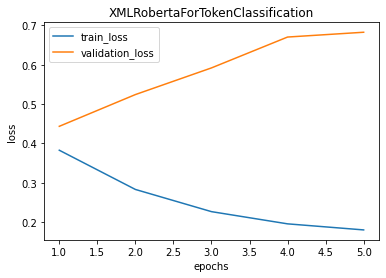

In [42]:
epochs = np.arange(1,6)
plt.plot(epochs,train_loss_lst,label='train_loss')
plt.plot(epochs,val_loss_lst,label='validation_loss')
plt.xlabel('epochs')
plt.ylabel('loss')
plt.title('XMLRobertaForTokenClassification')
plt.legend()
plt.show()

In [53]:
from transformers import AutoConfig
config = AutoConfig.from_pretrained('xlm-roberta-base')
config.num_labels

2

In [31]:
print(model)

DataParallel(
  (module): EntityModel(
    (bert): XLMRobertaForTokenClassification(
      (roberta): RobertaModel(
        (embeddings): RobertaEmbeddings(
          (word_embeddings): Embedding(250002, 768, padding_idx=1)
          (position_embeddings): Embedding(514, 768, padding_idx=1)
          (token_type_embeddings): Embedding(1, 768)
          (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (encoder): RobertaEncoder(
          (layer): ModuleList(
            (0): RobertaLayer(
              (attention): RobertaAttention(
                (self): RobertaSelfAttention(
                  (query): Linear(in_features=768, out_features=768, bias=True)
                  (key): Linear(in_features=768, out_features=768, bias=True)
                  (value): Linear(in_features=768, out_features=768, bias=True)
                  (dropout): Dropout(p=0.1, inplace=False)
                )
              